In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# import random
from random import sample

[1, 2, 3]


In [ ]:
df = pd.read_csv('/content/cleaned-dataset.tsv',sep = '\t')
train_df = df.loc[df['Season'] != '17/18']
test_df = df.loc[df['Season'] == '17/18']
# train_df,test_df = train_test_split(df, test_size=0.15)


train_df['tr_results'] = np.where(
    train_df['FTHG'] == train_df['FTAG'], 1, np.where(
    train_df['FTHG'] >  train_df['FTAG'], 2, 0))

test_df['te_results'] = np.where(
    test_df['FTHG'] == test_df['FTAG'], 1, np.where(
    test_df['FTHG'] >  test_df['FTAG'], 2, 0))

train_df = train_df[['tr_results','Commentary']]
test_df = test_df[['te_results','Commentary']]


<ipython-input-4-d6a32a4249b9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tr_results'] = np.where(
<ipython-input-4-d6a32a4249b9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['te_results'] = np.where(


In [ ]:
train_set = list(train_df.to_records(index=False))
test_set = list(test_df.to_records(index=False))

In [ ]:
import nltk
nltk.download('punkt')
train_set = [(result, word_tokenize(commentary.lower())) for result, commentary in train_set]
train_set[:3]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[(2,
  ['gus',
   'poyet',
   'says',
   'the',
   'excitement',
   'at',
   'sunderland',
   'has',
   'been',
   'reflected',
   'in',
   'the',
   'best',
   'week',
   'of',
   'training',
   'under',
   'his',
   'charge',
   '.',
   'the',
   'capital',
   'one',
   'cup',
   'final',
   'against',
   'manchester',
   'city',
   'looms',
   'next',
   'weekend',
   '–',
   'sunderland',
   "'s",
   'first',
   'major',
   'final',
   'for',
   '22',
   'years',
   '–',
   'and',
   'there',
   'is',
   'also',
   'an',
   'fa',
   'cup',
   'quarter-final',
   'at',
   'brighton',
   'or',
   'hull',
   '.',
   'yet',
   'nothing',
   'matters',
   'more',
   'than',
   'premier',
   'league',
   'survival',
   'and',
   ',',
   'with',
   'his',
   'team',
   'in',
   'the',
   'relegation',
   'zone',
   ',',
   'poyet',
   'is',
   'desperate',
   'for',
   'a',
   'tonic',
   '.',
   'arsenal',
   'want',
   'a',
   'response',
   'to',
   'the',
   'champions',
   'league',


In [ ]:
test_set = [(result, word_tokenize(commentary.lower())) for result, commentary in test_set]
test_set[:3]

[(2,
  ['there',
   'remain',
   'a',
   'number',
   'of',
   'question',
   'marks',
   'around',
   'arsenal',
   '’',
   's',
   'makeup',
   'for',
   'the',
   'new',
   'season',
   '.',
   'have',
   'they',
   'seen',
   'the',
   'last',
   'of',
   'alexis',
   'sánchez',
   '?',
   'when',
   'will',
   'they',
   'be',
   'able',
   'to',
   'field',
   'their',
   'first-choice',
   'defence',
   '?',
   'but',
   'it',
   'still',
   'appears',
   'to',
   'be',
   'a',
   'more',
   'stable',
   'environment',
   'than',
   'the',
   'one',
   'in',
   'which',
   'they',
   'began',
   'last',
   'season',
   '.',
   'they',
   'lost',
   ',',
   'crucially',
   'as',
   'it',
   'turned',
   'out',
   ',',
   'to',
   'liverpool',
   'on',
   'the',
   'opening',
   'day',
   ';',
   'arsène',
   'wenger',
   'knows',
   'a',
   'fast',
   'start',
   'is',
   'important',
   'this',
   'time',
   'around',
   'to',
   'make',
   'the',
   'idea',
   'of',
   'a',
   

In [ ]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [train_set, test_set]:
    for results, commentary in ds:
        for token in commentary:
            if token not in index2word:
                index2word.append(token)

In [ ]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [ ]:
seq_length = 100

In [ ]:
def encode_and_pad(commentary, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(commentary) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(commentary)
        encoded = [word2index[w] for w in commentary]
        return sos + encoded + eos + pad * n_pads 
    else: # commentary is longer than possible; truncating
        encoded = [word2index[w] for w in commentary]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [ ]:
train_encoded = [(encode_and_pad(commentary, seq_length), label) for label, commentary in train_set]
test_encoded = [(encode_and_pad(commentary, seq_length), label) for label, commentary in test_set]

In [ ]:
for i in train_encoded[:3]:
    print(i)

([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6, 14, 15, 16, 17, 18, 19, 20, 21, 6, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 9, 33, 34, 35, 25, 36, 37, 38, 32, 39, 40, 41, 42, 43, 44, 24, 45, 8, 46, 47, 48, 21, 49, 50, 51, 52, 53, 54, 55, 56, 39, 57, 58, 19, 59, 13, 6, 60, 61, 57, 4, 41, 62, 36, 63, 64, 21, 65, 66, 63, 67, 68, 6, 69, 55, 70, 26, 71, 72, 21, 73, 74, 2, 0, 0, 0, 0], 2)
([1, 75, 63, 76, 58, 77, 78, 13, 79, 57, 80, 81, 82, 83, 84, 85, 63, 86, 87, 88, 89, 90, 91, 8, 92, 93, 13, 94, 21, 95, 96, 41, 93, 97, 63, 98, 99, 39, 100, 101, 41, 13, 102, 103, 63, 104, 105, 21, 36, 87, 57, 106, 107, 41, 108, 26, 19, 109, 110, 57, 111, 112, 113, 114, 115, 116, 117, 97, 63, 118, 99, 21, 119, 120, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)
([1, 121, 122, 68, 123, 43, 124, 125, 36, 27, 126, 57, 89, 127, 128, 129, 130, 131, 132, 133, 134, 68, 135, 136, 137, 138, 139, 16, 140, 13, 6, 141, 142, 21, 143, 144, 145, 11, 146, 8, 147, 148, 149, 150, 151, 33, 1

In [ ]:
batch_size = 20

train_x = np.array([commentary for commentary, result in train_encoded])
train_y = np.array([result for commentary, result in train_encoded])
test_x = np.array([commentary for commentary, result in test_encoded])
test_y = np.array([result for commentary, result in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 8), torch.zeros(1, batch_size, 8))

In [ ]:
model = BiLSTM_SentimentAnalysis(len(word2index), 16, 8, 0.2)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [ ]:
epochs = 50
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)
    epoch_acc = []
    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            _, preds = torch.max(out, 1)
            preds = preds.to("cpu").tolist()
            epoch_acc.append(accuracy_score(preds, target.tolist()))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    
    losses.append(loss.item())
    sum(epoch_acc)/len(epoch_acc)

In [ ]:
sum(epoch_acc)/len(epoch_acc)

0.5029411764705882

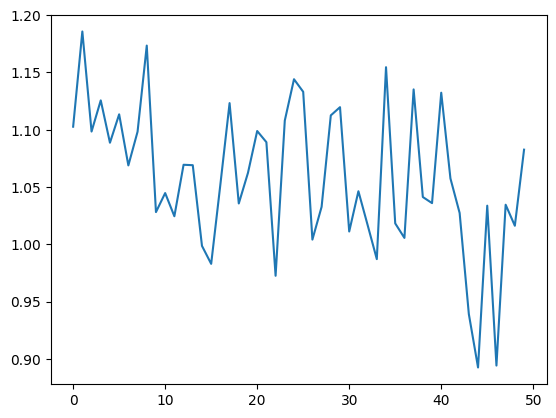

In [ ]:
plt.plot(losses)

In [ ]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)
    model.eval()
    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        print(preds)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
tensor([2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2],
       device='cuda:0')
tensor([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
tensor([1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
       device='cuda:0')
tensor([2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
tensor([2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2],
 

0.4615384615384616